## Transfer Learning in HuggingFace with PyTorch: 
* **Train only only n last layers from the pretrained model, freezing rest of the weights**
* **And, add one trainable linear layer at the end of this pretrained model**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.datasets import fetch_20newsgroups

from transformers import BertForSequenceClassification, BertTokenizer, BertModel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

import torch
from torch import nn

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

c:\Users\manpresingh\Anaconda3\envs\python_38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### References:
* **https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f**
* **https://huggingface.co/transformers/v3.3.1/training.html#pytorch**
* **https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b**
* **https://blog.insightdatascience.com/using-transfer-learning-for-nlp-with-small-data-71e10baf99a6**

### BERT Classification Arch:

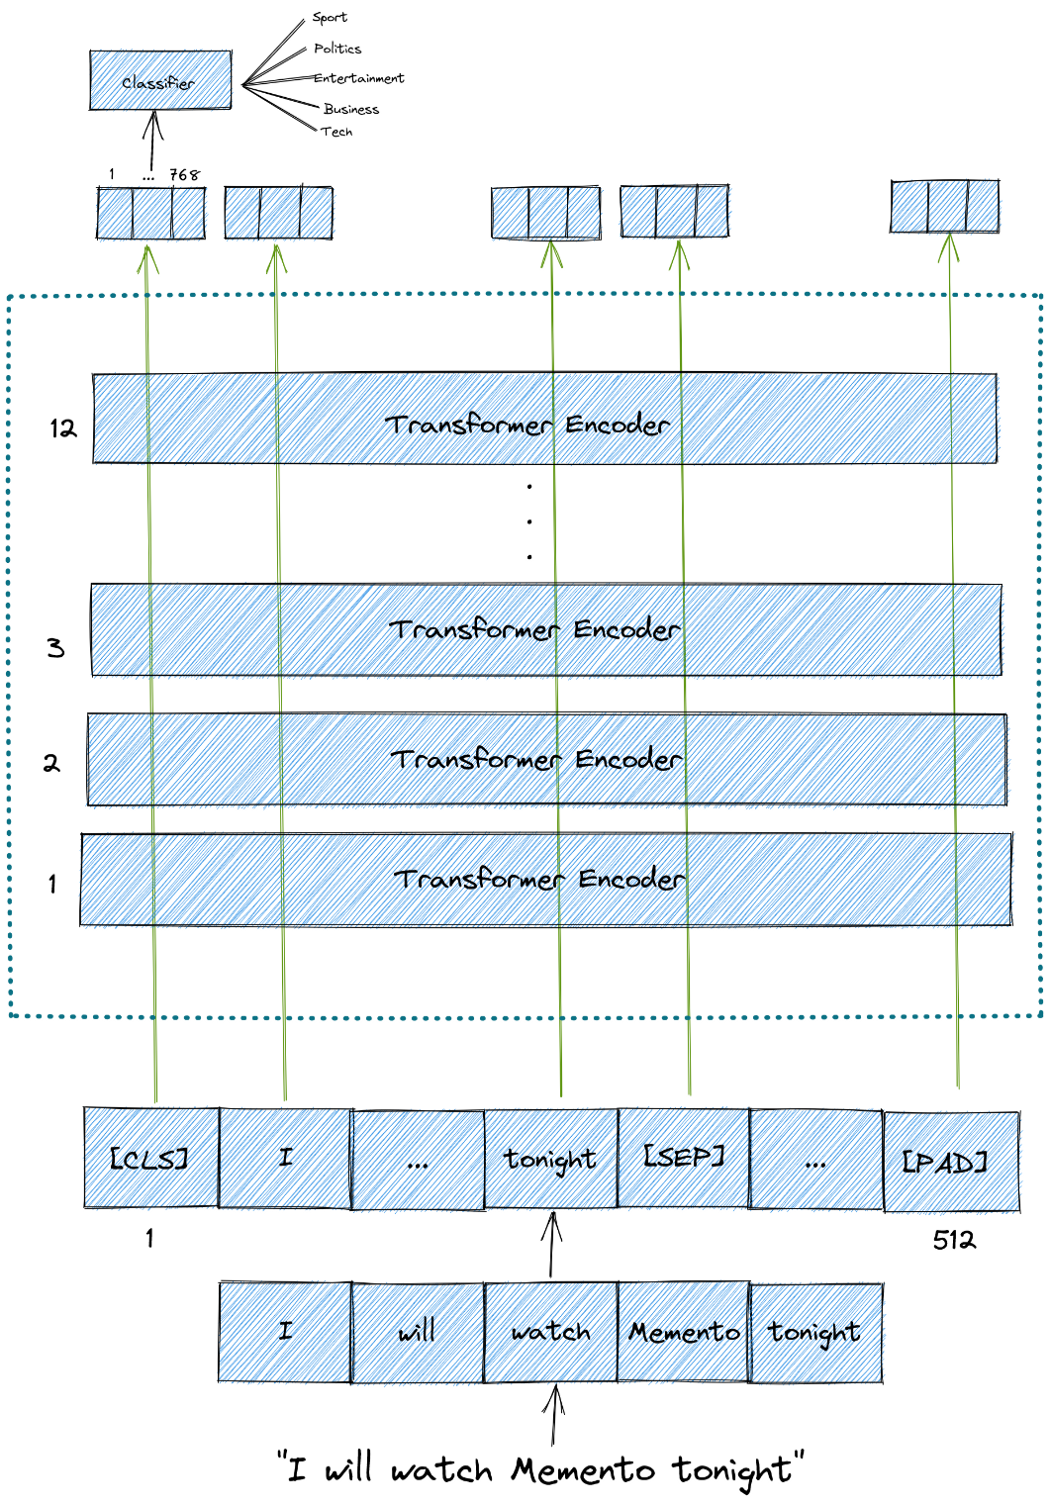

### BERTModel vs BertForSequenceClassification vs BertForPreTraining
* **https://stackoverflow.com/questions/66596142/bertmodel-or-bertforpretraining** 

In [3]:
pd.options.display.max_rows=100
pd.options.display.max_columns=100

In [2]:
model = BertModel.from_pretrained('google/bert_uncased_L-2_H-128_A-2')
## it's a TineyBERT model

### VERY IMPORTANT ###
* **NOTE: If I use BertForSequenceClassification, then I would not have to add any linear or any sigmoid layer at the end to do the classification task.I can directly use this model to predict the classes.** 
* **We are using BERTModel, since we want to customize our linear layers at the end to have trainable layers after the pooling layer**
* **Different size of BERT models: https://huggingface.co/google/bert_uncased_L-4_H-512_A-8**

In [3]:
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2', do_lower_case=True)

In [4]:
model.named_parameters

<bound method Module.named_parameters of BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-1): 2 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=128, out_features=128, bias=True)
            (key): Linear(in_features=128, out_features=128, bias=True)
            (value): Linear(in_features=128, out_features=128, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=128, out_features=128, bias=True)
            (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
            (dro

In [5]:
count=0
for name, param in model.named_parameters():
    print(name)
    count+=1

embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.weight
encoder.layer.0.attention.self.query.bias
encoder.layer.0.attention.self.key.weight
encoder.layer.0.attention.self.key.bias
encoder.layer.0.attention.self.value.weight
encoder.layer.0.attention.self.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query.weight
encoder.layer.1.attention.self.query.bias
encoder.layer.1.attention.self.key.weight
encoder.layer.1.attention.self.key

In [8]:
count

39

### Transfer Learning - Freezing the encoding layers and keeping only last 2 layers (weight & bias) for training

In [6]:

## Training only last 2 params of the last classifier layer - weight & bias.
## Rest are frozen
## Freezing the weights of the layers so that training doesn't happen on these layers:

for name in list(model.named_parameters())[:-2]:
    param.requires_grad=False
    #print(name)

In [7]:
tokenizer

BertTokenizer(name_or_path='google/bert_uncased_L-2_H-128_A-2', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

### Sklearn dataset

In [8]:
dataset = fetch_20newsgroups(subset="all", shuffle=True, remove=("headers", "footers", "quotes"))

In [9]:
len(dataset.data)

18846

In [10]:
## Taking only small data for this task
X=dataset.data[0:5000]
Y=dataset.target[0:5000]

In [11]:
set(Y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [12]:
len(set(Y))

20

In [13]:
trainx, validx, trainy, validy=train_test_split(X, Y, test_size=.2, stratify=Y)

In [14]:
len(trainx)

4000

### Working of BERTTokenizer:

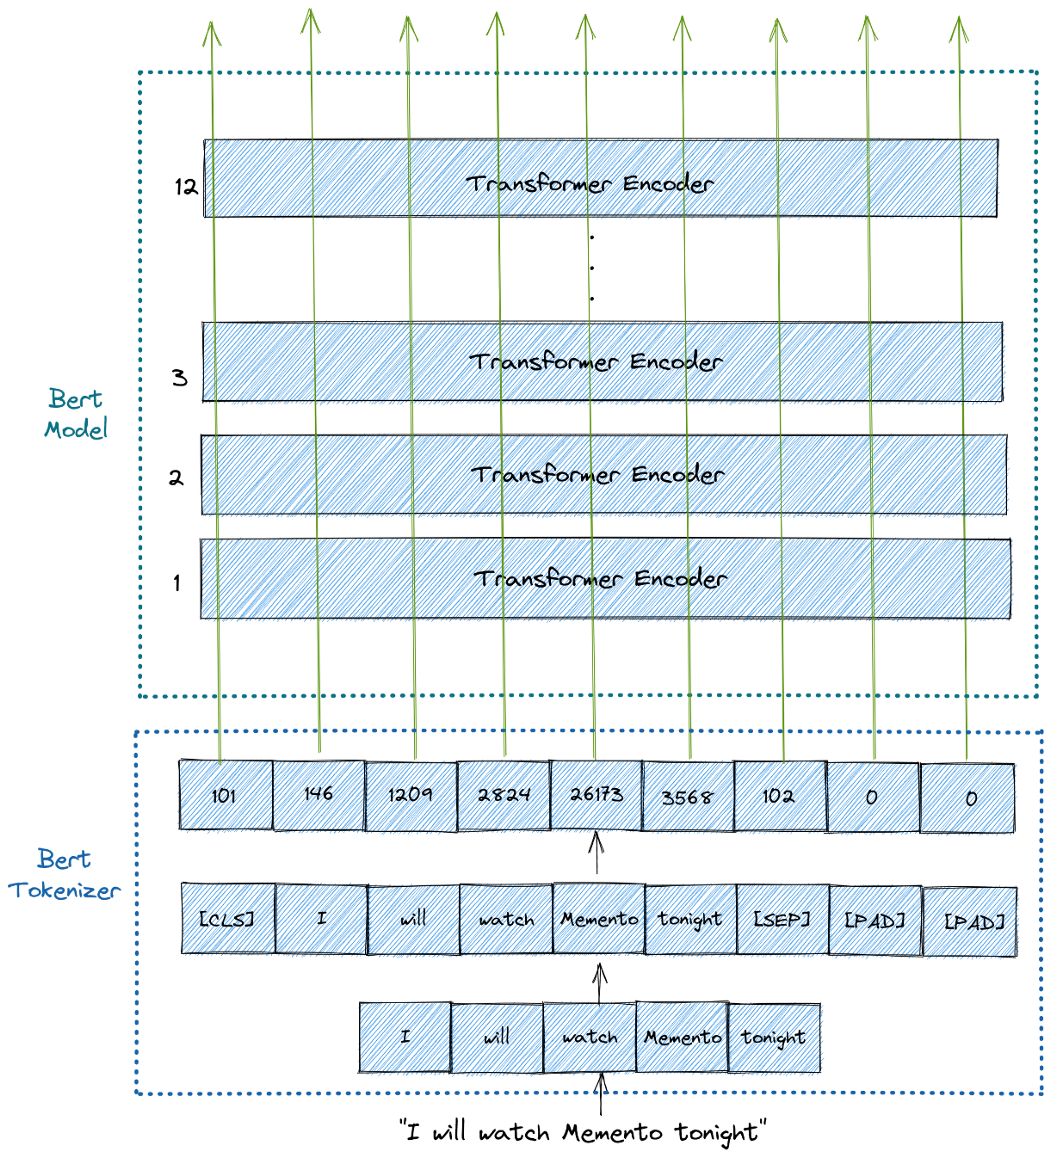

### Creating Dataset:

In [15]:
## torch Dataset class expects len and getitem functions apart from init

class Dataset(torch.utils.data.Dataset):
    
    def __init__(self,X, Y, max_len):
        self.max_len=max_len
        self.labels = Y
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = self.max_len, truncation=True,
                                return_tensors="pt") for text in X]
        
    def classes(self):
        return self.labels
        
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    
    def get_batch_texts(self, idx):
        return self.texts[idx]
    
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        
        return batch_texts, batch_y
        

In [16]:
train_dataset = Dataset(trainx, trainy,150)

In [17]:
train_dataset.get_batch_labels(0)

array(19)

In [18]:
train_dataset.get_batch_texts(0)['input_ids'][0]

tensor([  101,  2045,  2020,  2070,  3522,  8973,  1999,  1996,  7593,  2055,
        18103,  2426,  2670,  7550,  2015,  1012,  1045,  6866,  1037, 12654,
         2058,  1999,  2978,  1012,  7201,  2121,  2615,  1012, 21359,  2050,
         1010,  1998,  1045,  6814,  2008,  2009,  2453,  2022,  6179,  2182,
         1012,  3602,  2008,  1045,  2079,  2025,  9352,  5993,  2030, 21090,
         2007,  2151,  1997,  2054,  4076,  1024,  1045,  2556,  2009,  2004,
         2592,  1012,  1008,  2005,  1037,  2460, 12654,  1024,  1037,  2670,
         7550,  2315,  6554,  9079,  2626,  1037,  2338,  6815,  2008,  2489,
         9335,  2239,  2854,  2003,  1037,  4676, 25876,  2007,  7988,  1012,
         1006,  2720,  9079,  1005,  1055,  2269, 19164,  7988,  1010,  1998,
         2720,  9079,  7499,  2015,  2008,  2006,  1996,  6701,  2015,  1012,
         1007,  1996, 24829,  2278,  1005,  1055,  2188,  6416,  2604,  2950,
         2019,  6970,  7011,  8939,  7409,  2533,  1010,  2029, 

In [19]:
tokenizer.decode(train_dataset.get_batch_texts(0)['input_ids'][0])

"[CLS] there were some recent developments in the dispute about masonry among southern baptists. i posted a summary over in bit. listserv. christia, and i suppose that it might be useful here. note that i do not necessarily agree or disagree with any of what follows : i present it as information. * for a short summary : a southern baptist named larry holly wrote a book claiming that freemasonry is a religion incompatible with christianity. ( mr holly's father rejects christianity, and mr holly blames that on the masons. ) the sbc's home missions board includes an interfaith witness department, which studies other religions and how to teach them about christ. a few years ago, they were ordered to produce [SEP]"

In [20]:
trainx[0]

'There were some recent developments in the dispute about Masonry among\nSouthern Baptists.  I posted a summary over in bit.listserv.christia, and\nI suppose that it might be useful here.  Note that I do not necessarily\nagree or disagree with any of what follows: I present it as information.\n\n *\n\nFor a short summary:  a Southern Baptist named Larry Holly wrote a book\nclaiming that Freemasonry is a religion incompatible with Christianity.\n(Mr Holly\'s father rejects Christianity, and Mr Holly blames that on the\nMasons.)\n\nThe SBC\'s Home Missions Board includes an interfaith witness department,\nwhich studies other religions and how to teach them about Christ.  A few\nyears ago, they were ordered to produce a report on Masonry: they concluded\nthat it was not a religion, and therefore was outside their speciality.\nHowever, Mr Holly led a movement of people who oppose Masonry, and\nlast year the Convention again ordered the HMB to study Masonry.  (I got the\nfeeling that they w

In [21]:
#encoding['input_ids'][0]

In [22]:
#tokenizer.decode(encoding['input_ids'][0])

In [23]:
test_dataset = Dataset(validx, validy,400)

In [24]:
batch_size=16

In [25]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [47]:
nn.Linear(128,1)

Linear(in_features=128, out_features=1, bias=True)

### Building the Model for Transfer Learning

In [30]:
class MyBERTClassifier(nn.Module):
    
    def __init__(self, model, dropout, num_classes):
        super(MyBERTClassifier, self).__init__()
        
        self.bert=model
        self.dropout = nn.Dropout(dropout)
        self.linear=nn.Linear(128, num_classes) ## Use this if you want add one more layer to train
        self.relu=nn.ReLU()
        
        
    def forward(self, input_id, mask):
        _,pooled_output = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        ## _ containes the embeddings and pooled_output is the BERT pooling layer
        relu_layer = self.relu(pooled_output)
        dropout_output = self.dropout(relu_layer)
        linear_output = self.linear(dropout_output) ## Additional trainable linear layer
        final_layer = self.relu(linear_output) 
        ## Note: We are not using sigmoid, since it's a multiclass problem
        return final_layer

In [31]:
mymodel = MyBERTClassifier(model,.2,20)

In [33]:
epochs = 3
learning_rate=.001

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
mymodel.train()
for epoch in range(epochs):
    myloss = []
    for text, label in tqdm(train_dataloader):
        mask = text['attention_mask']
        input_id = text['input_ids'].squeeze(1)
        
        output = mymodel(input_id, mask)
        
        batch_loss = criterion(output, label.long())

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        myloss.append(round(batch_loss.item(),5))
    print(f'Epoch {epoch+1} of {epochs}; Mean_Loss =  {round(np.mean(myloss),8)}')

100%|██████████| 250/250 [00:22<00:00, 10.89it/s]


Epoch 1 of 3; Mean_Loss =  2.89444408


100%|██████████| 250/250 [00:27<00:00,  9.07it/s]


Epoch 2 of 3; Mean_Loss =  2.60151544


100%|██████████| 250/250 [00:33<00:00,  7.41it/s]

Epoch 3 of 3; Mean_Loss =  2.4483832


In [49]:
_, xyz = mymodel.bert(input_ids=input_id, attention_mask=mask,return_dict=False)

In [51]:
_[0].shape
# This embedding of each of the 150 tokens
# Why 150 ? because we fixed the max_length as 150

torch.Size([150, 128])

In [61]:
# Similarly, this is for all the 16 samples as 16 is our batch
_.shape

torch.Size([16, 150, 128])

In [55]:
xyz[0].shape
# This is the output of classification token being passed through the pooled layer
# How ? Let's understand if we had only 1 input sample
# classification token shape is 1,128
# and pooled laye is 128,128
# Now (1,128).(128,128) = (1,128)
# Now, if we hadd another layer of ours which has shape 128,5  (now here 5 means 5 classes - multiclass prob)

# So, finaloutptut is: (1,128).(128,5)= (1,5)
# And when we add softmax, it will give prob of each class

# We can do same for sigmoid:
# (1,128).(1,1)=(1,1) and pass it through sigmoid function


# Now, both of these can be done for a batch of n also where the final output will:
# n,5 for multiclass prob depicting prob of 5 classes for n samples
#  n,1 for binary class depticing prob of 1 for n samples   

torch.Size([128])

In [62]:
nn.Linear(128,5)(xyz[0]).shape

torch.Size([5])

In [54]:
# mymodel.forward()

In [44]:
len(test_dataset)/batch_size

62.5

In [45]:
mymodel.eval()
output=[]
for test_input, test_label in test_dataloader:
            #test_label = test_label.to(device)
            mask = test_input['attention_mask']#.to(device)
            input_id = test_input['input_ids'].squeeze(1)#.to(device)

            output.append(mymodel(input_id, mask))

In [46]:
from sklearn.metrics import roc_auc_score

In [47]:
len(output)

63

In [48]:
len(output[0])

16

In [49]:
len(output[15])

16

In [50]:
64*15 +40

1000

### One Hot Encoding of testY & Preparing the predicted data for AUC calculation

In [51]:
myoutput=[]
with torch.no_grad():
    for i in range(len(output)):
        for j in range(len(output[i])):
            myoutput.append(output[i][j].numpy())
        #myoutput.append(list(output[i].numpy()))
myoutput2=np.stack(myoutput, axis=0)

In [52]:
len(myoutput2)

1000

In [53]:
myoutput2[0]

array([0.8001104 , 0.        , 0.14402354, 0.6169639 , 0.        ,
       0.        , 0.        , 1.5026703 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.18931457,
       0.02412599, 1.2349203 , 0.        , 0.3456192 , 0.5646311 ],
      dtype=float32)

In [54]:
myoutput2_df=pd.DataFrame(myoutput2)

In [55]:
myoutput2_df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.80011,0.0,0.144024,0.616964,0.0,0.000000,0.0,1.50267,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.189315,0.024126,1.234920,0.0,0.345619,0.564631
1,0.00000,0.0,0.339343,0.000000,0.0,0.097384,0.0,0.00000,0.0,0.0,0.262163,2.525116,0.278539,0.0,0.000000,0.000000,0.317206,0.0,0.567688,0.647402


In [56]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

In [57]:
validy_df = pd.DataFrame(validy, columns=['target_label'])

In [58]:
encoder_df = pd.DataFrame(one_hot_encoder.fit_transform(validy_df).toarray())

In [59]:
encoder_df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### The model has performed quite good when we had less data (only 4k to train) over 20 classes!

In [73]:
auc_score = round(roc_auc_score(encoder_df,myoutput2_df, multi_class='ovr', average='weighted'),2) 
print(f'Average OVR-(One v/s Rest) AUC is {auc_score}')

Average OVR-(One v/s Rest) AUC is 0.79
